# Practical Session 7 - Active contour using level sets

$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\norm}[1]{\|#1\|}$



**Vrushank Agrawal**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from scipy import ndimage
import pylab
from skimage.color import rgb2gray

In [ ]:
# Run this the first time you launch the kernel on Colab.
! git clone https://github.com/AgatheSenellart/DataMAA308.git
! mv DataMAA308/data data
! mv DataMAA308/Images Images

Cloning into 'DataMAA308'...
remote: Enumerating objects: 461, done.
remote: Total 461 (delta 0), reused 0 (delta 0), pack-reused 461
Receiving objects: 100% (461/461), 98.68 MiB | 30.12 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In this practical session, we guide you through implementing a method of *active contour segmentation* using level sets. 
In the level set formalism, a contour or a curve $ (\gamma(t))_{t=0}^1 $
corresponds to the
zero level of a function $\phi : \RR^2 \rightarrow \RR $
$$ \enscond{\gamma(s)}{ s \in [0,1] } = \enscond{x \in \RR^2}{\phi(x)=0}. $$

We modify the contours by modifying the level function $\phi$.

First we introduce some plotting functions. 


# Plotting Functions

In [ ]:
def plot_levelset(Z,f=None,level=0):
    """
    Plots the level set of the function f on Z. 
    
    Args :
        Z (array nr,nc) : The grid/image or domain we work on.
        f (array nr,nc) : The values of the function on the domain given by Z. 
            If None is provided, f is taken equal to Z.
        level (float) : The level of the function f we want to visualize. Default to 0.
    f, Z : (nr,nc)
    """
    if f is None:
        f = np.copy(Z)
        
    n,p = np.shape(Z)
    X,Y = np.meshgrid(np.arange(0,p),np.arange(0,n))
    plt.contour(X, Y, f,[level],linewidths=2, colors="red")
    imgplot = plt.imshow(Z, interpolation='nearest')
    imgplot.set_cmap('gray')
    pylab.axis('off')
    
    
def rescale(f,a=0,b=1):
    """
        Rescale linearly the dynamic of a vector to fit within a range [a,b]
    """
    v = f.max() - f.min()
    g = (f - f.min()).copy()
    if v > 0:
        g = g / v
    return a + g*(b-a)

# Importation of images

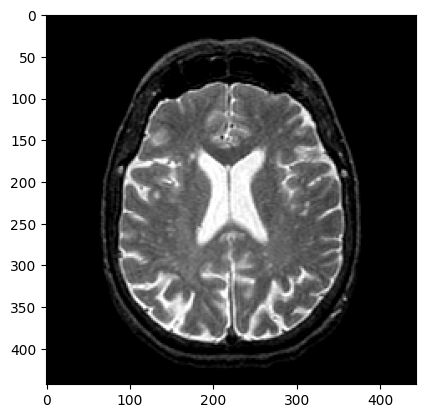

In [ ]:
anchor = mpimg.imread('Images/image_redanch.jpg') 
cortex = rescale(mpimg.imread('Images/cortex.bmp'))
I = cortex
I_gray = rgb2gray(I)
nr,nc= I_gray.shape
plt.imshow(I_gray,cmap='gray')
plt.show()

# Mean curvature motion

<!-- The mean curvature motion corresponds to the minimizing flow of the
length of the curve
$$ \int_0^1 \norm{\gamma'(s)} d s. $$ -->
We consider a first way to update a level function $\phi : \mathbb R^2 \to \mathbb R$ to try and fit our segmentation.

In the mean curvature motion, the evolution of the level function $\phi_t$ for $t \geq 0$ is given by 
the following PDE
$$
\pd{\phi_t}{t} = G(\phi_t)
$$
with $G : \mathcal F(\mathbb R^2, \mathbb R) \to F(\mathbb R^2, \mathbb R)$ given by the expression :
$$
G(\phi) = \norm{\nabla \phi} \text{div}
      \pa{  \frac{\nabla \phi}{\norm{\nabla \phi}}}
$$
and where $\nabla \phi_t(x) \in \RR^2$ is the spatial gradient.


This flow is computed using Euler's method :
$\phi^{(0)} = \phi_0$ and
$$ \phi^{(\ell+1)} = \phi^{(\ell)} + \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough time step. We choose the maximum time $t_{max} \geq 0$ for which we stop iterating.

**This first method allows you to implement important functions you will need in Geodesic Active Contour part, and code the core of the full algorithm. \
But here, as the algorithm does not take into account the image during the minimization process, you consider that your initial $\phi^0$ depends on $I_0$.**


**TODO 1** : Implement the `spatial_grad` and div functions that computes the gradient of the level_set function and the divergence of a vector field.

In [ ]:
def spatial_grad(M):
    """Computes the gradient of the level set function M.

    Args:
        M (array nr, nc): The level function defined on a grid nrxnc.

    Returns:
        gx array nr, nc : The derivate of M with respect to the first coordinate (x).
        gy array nr, nc : The derivate of M with respect to the second coordinate (y).

    """
    gx, gy = np.gradient(M)
    return gx, gy

def div(Px, Py):
    """
    Computes the divergence of a vector field defined on a grid.

    Args:
        Px (array nr, nc): The value of the first coordinate of the vector field in each point of the grid nr, nc.
        Py (array nr, nc): The value of the second coordinate of the vector field in each point of the grid nr, nc.

    Returns:
        d (array nr, nc) : The value of the divergence in each point of the grid.
    """
    dx = spatial_grad(Px)[0]
    dy = spatial_grad(Py)[1]
    return dx + dy

**TODO 2** : Implement the function G.

In [ ]:
def G_mean_curvature(phi):
    """Implement the G function described above for a level set phi.

    Args:
        phi (array nr,nc): The level function values on a grid nr,nc.

    Returns:
        G array nr,nc : The G function values on the grid nr,nc.
    """
    gx, gy = spatial_grad(phi)
    norm = np.sqrt(gx**2 + gy**2) + 1e-10
    return norm * div(gx/norm, gy/norm)

**TODO 3** : Complete the gradient descent function that computes the iterations of the level set $\phi_t, 0 \leq t \leq t_{max}$.

In [ ]:
def euler_mean_curvature(phi0,tau,Tmax,I0):
    '''
    Args :
        phi0 (array nr,nc) : The inial level function.
        tau (float) : time step size, > 0, be careful to not have a too big time step !
        Tmax (int): maximum time of the evolution
        I0 (array nr,nc): your gray image to segment
    ------
    returns
        final_phi (array nr,nc)
    
    '''
    phi = phi0.copy()
    n_steps = int(Tmax / tau)
    for _ in range(n_steps):
        phi += tau * G_mean_curvature(phi)
    return phi
   

## Application
Let's test your implementation on a simple example. Below we create an artificial image `phi_3`. 

In [ ]:
nr = 200
nc = 300
Y,X = np.meshgrid(np.arange(1,nc+1), np.arange(1,nr+1))

r = nr/4.
c = np.asarray([nc,nc])/4.
phi1 = (np.maximum(abs(X-c[0]), abs(Y-c[1]))-r)


r = nr/4.
c = np.asarray([nc,nc])/2.1
phi2 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

phi3 = np.minimum(phi1, phi2)

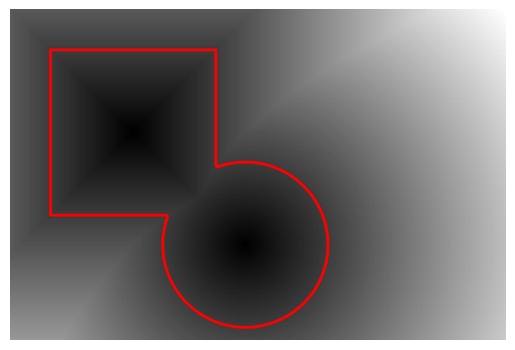

In [ ]:
# Plots the image and the natural level set given by the image intensity
plot_levelset(phi3, f=phi3)

**TODO 4: Execute your algorithm on the "image" $\phi^3$ given above.\
Then change initial $\phi^0$ and see what happens.**

In [ ]:
tau = 0.4
Tmax = 200

phi = euler_mean_curvature(phi3,tau,Tmax,phi3)

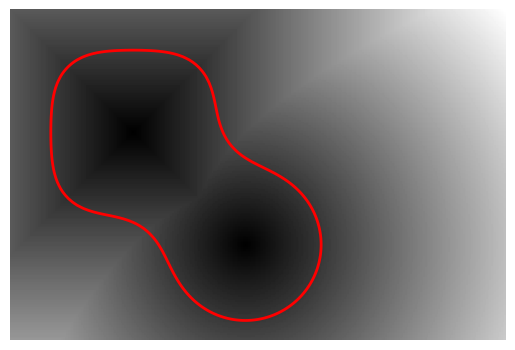

In [ ]:
plot_levelset(Z = phi3,f = phi)

# Geodesic Active Contour

In the Mean Curvature Motion, the evolution of the curve does not depend on the image ! Only the initial level function $\phi_0$ can be chosen to fit the image and the Mean Curvature Motion "smoothes" the contour. Now we see a more segmentation method that makes use of the image to update the level functions $\phi_t$ depending on the image gradient. 
This method re-uses functions implemented in the first part.

Geodesic active contours compute local minimum of a weighted geodesic
distance that attract the curve toward the features of the background
image.

Given a background image $I_0$ to segment, one needs to compute
an edge-stopping function $W$.
It should be small in area of high gradient, and high in area of small gradient.


We use here
$$W(x) = \alpha + \frac{\beta}{\epsilon + d_0(x) }
      \qwhereq d_0(x) = \norm{\nabla I_0(x)} $$




The geodesic active contour minimizes a weighted length of curve
$$\underset{\gamma}{min} \int_0^1 \norm{\gamma'(s)} W(\gamma(s)) d s $$


The level set implementation of the gradient descent of this energy reads
$$ \pd{\phi_t}{t} = G(\phi_t)
  \qwhereq G(\phi) = \norm{\nabla \phi} \text{div}\pa{
          W \frac{\nabla \phi}{\norm{\nabla \phi}}
  } $$


This is implemented using an Euler method.
$$ \phi^{(\ell+1)} = \phi^{(\ell)} + \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough.




Define an initial $\phi^0$. You can plot, together with your image I_gray, with plot_levels function.\
Here your $\phi^0$ is not equal to your image $I_0$ !

In [ ]:
nr,nc = I_gray.shape
Y,X = np.meshgrid(np.arange(1,nc+1), np.arange(1,nr+1))
r = nr/3.
c = np.asarray([nc,nc])/2.
phi0 = np.maximum(abs(X-c[0]), abs(Y-c[1])) - r

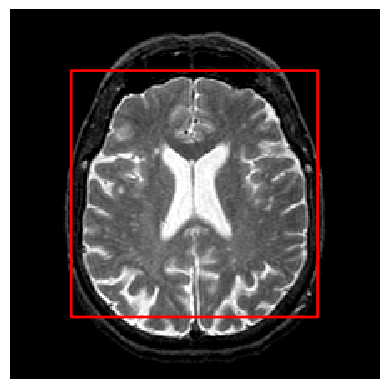

In [ ]:
plot_levelset(I_gray,f=phi0)

**TODO 5** : Compute $W$ and plot it to see how it looks.

In [ ]:
def compute_W(I):
    alpha = 1
    beta = 1
    epsilon = 1
    gx,gy = spatial_grad(I)
    norm = np.sqrt(gx**2 + gy**2)
    W = alpha + beta / (epsilon + norm**2)
    return W

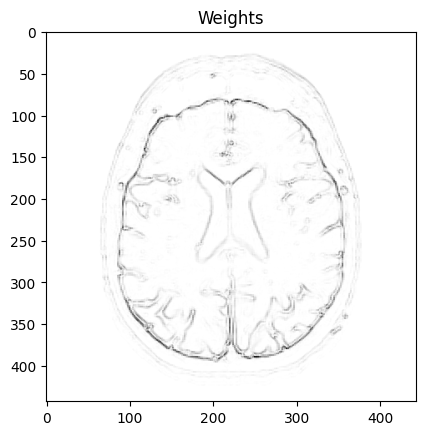

In [ ]:
plt.figure()
plt.imshow(compute_W(I_gray),cmap='gray')
plt.title('Weights')
plt.show()

**TODO 6** : Implement the function `G_geodesic` that implements the $G$ function described above for the Geodesic Active Contours method. 

In [ ]:
def G_geodesic(phi,W):
    """Implement the G function described above for a level set phi.

    Args:
        phi (array nr,nc): The level function values on a grid nr,nc.
        W (array nr,nc) : The edge stopping function

    Returns:
        G array nr,nc : The G function values on the grid nr,nc.
    """
    
    gx,gy = spatial_grad(phi)
    norm = np.sqrt(gx**2 + gy**2) + 1e-10
    return norm * div(W*(gx/norm), W*(gy/norm))

**TODO 7** In a similar fashion as `euler_mean_curvature`, implement `euler_geodesic`that computes the evolution in time of $\phi$ as given by the equations above. 

In [ ]:
def euler_geodesic(phi0,tau,Tmax,I0,W):
    '''
    Args :
        phi0 (array nr,nc) : The inial level function.
        tau (float) : time step size, > 0, be careful to not have a too big time step !
        Tmax (int): maximum time of the evolution
        I0 (array nr,nc): your gray image to segment,
        W (array nr,nc): The edge stopping function.
    ------
    returns
        final_phi (array nr,nc)
    
    '''
    phi = phi0.copy()
    n_steps = int(Tmax/tau)
    for _ in range(n_steps):
        phi += tau * G_geodesic(phi,W)
    return phi

## Application

**TODO 8** : 
Run the geodesic method on `I_gray`. 
Depending on the image you want to segment, and your initial $\phi^0$, you may need a huge number of iterations to see significative modifications of your contour.

In [ ]:
tau = 0.25
Tmax = 1000

phi = euler_geodesic(phi0,tau,Tmax,I_gray,compute_W(I_gray))

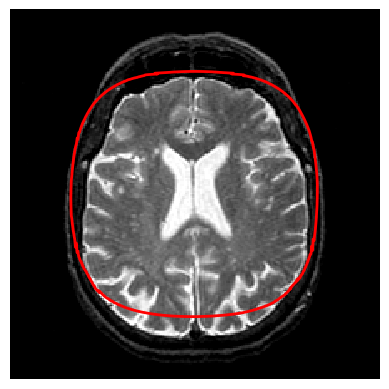

In [ ]:
plot_levelset(I_gray,phi)